## Step 1: Download images of birds and non-birds

In [5]:
# If not inslalled, pip install fastai and duckduckgo_search

# First we needs to define the search_images function

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [6]:
# Then we can search for images

urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'http://hdqwalls.com/wallpapers/colorful-parrot-bird.jpg'

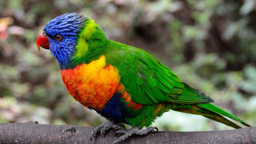

In [7]:
# Use download_url to get the image and fastai to display it
from fastdownload import download_url

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *

im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


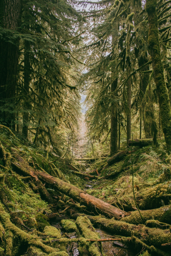

In [8]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [9]:
from time import sleep

searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train our model

In [10]:
# Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

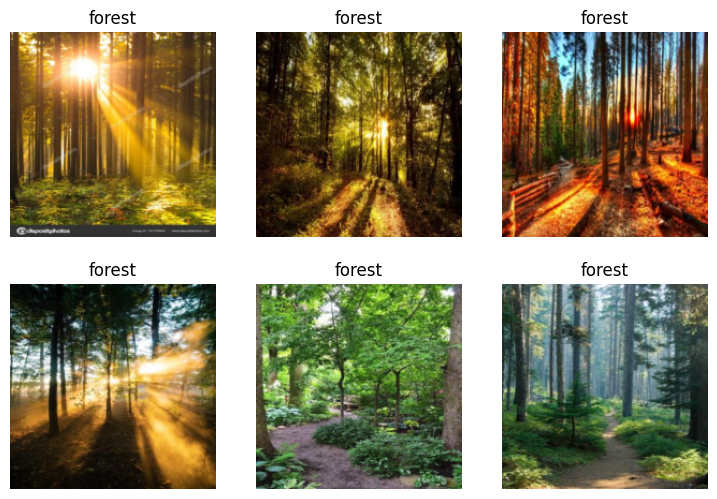

In [14]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [15]:
# We'll use a pretrained ResNet18

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/ondrej.drapalik/opt/anaconda3/envs/fastai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ondrej.drapalik/opt/anaconda3/envs/fastai-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/ondrej.drapalik/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:12<00:00, 3.70MB/s]
[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


epoch,train_loss,valid_loss,error_rate,time
0,0.764222,0.215467,0.151515,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.120395,0.019069,0.000000,00:13
1,0.087195,0.012853,0.000000,00:13
2,0.058812,0.013835,0.000000,00:16


## Step 3: Use our model

In [22]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9985
